## Imports

In [18]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Ingest data

In [52]:
df = pd.read_csv("../data/data_2022_with_geom.csv")
df.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom
0,950226616,2022-04-20 12:10:00,TRC7.2.22,STR CLEAN,1318 FILBERT ST,CA,V507699,84.0,05/01/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
1,952126114,2022-06-17 16:12:00,TRC7.2.20,RES/OT,1318 FILBERT ST,CA,BV44D97,96.0,07/17/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
2,950441903,2022-04-23 15:13:00,V5200,NO PLATES,1318 FILBERT ST,CA,V507699,121.0,05/18/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
3,948460144,2022-02-22 11:54:00,TRC7.2.20,RES/OT,1318 FILBERT ST,TX,HVT6737,96.0,05/23/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
4,948169644,2022-02-17 13:39:00,TRC7.2.20,RES/OT,1318 FILBERT ST,OH,HQA6554,96.0,04/03/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)


In [53]:
# convert to geodf for spatial join

df['geom'] = df.geom.apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')
df.crs = 'EPSG:4326'

In [54]:
# convert date column from string to datetime.

df['Citation Issued DateTime'] = pd.to_datetime(df['Citation Issued DateTime'])

In [55]:
# add a column for just date

df['Citation Issued DateTime'].dt.date

0          2022-04-20
1          2022-06-17
2          2022-04-23
3          2022-02-22
4          2022-02-17
              ...    
1127684    2022-11-08
1127685    2022-11-08
1127686    2022-11-08
1127687    2022-11-08
1127688    2022-11-08
Name: Citation Issued DateTime, Length: 1127689, dtype: object

## Beewoop It's EDA Time
I want to explore the geospacial and time's relationship with respect to parking ticket revenues. Some potential plots that would be interesting.
- Parking violation revenue over time
- Revenue by type of violations
This should also be stratified by neighborhoods.

In [56]:
# Let's look at the dataset again
df.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom
0,950226616,2022-04-20 12:10:00,TRC7.2.22,STR CLEAN,1318 FILBERT ST,CA,V507699,84.0,05/01/2022 12:00:00 AM,POINT (-122.42120 37.80002)
1,952126114,2022-06-17 16:12:00,TRC7.2.20,RES/OT,1318 FILBERT ST,CA,BV44D97,96.0,07/17/2022 12:00:00 AM,POINT (-122.42120 37.80002)
2,950441903,2022-04-23 15:13:00,V5200,NO PLATES,1318 FILBERT ST,CA,V507699,121.0,05/18/2022 12:00:00 AM,POINT (-122.42120 37.80002)
3,948460144,2022-02-22 11:54:00,TRC7.2.20,RES/OT,1318 FILBERT ST,TX,HVT6737,96.0,05/23/2022 12:00:00 AM,POINT (-122.42120 37.80002)
4,948169644,2022-02-17 13:39:00,TRC7.2.20,RES/OT,1318 FILBERT ST,OH,HQA6554,96.0,04/03/2022 12:00:00 AM,POINT (-122.42120 37.80002)


### Stratified by day

In [68]:
# Group data by date and sum the fine amounts
grouped_data = df.groupby('Citation Issued DateTime')['Fine Amount'].sum()

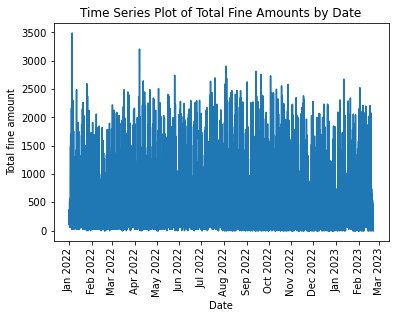

In [69]:
# Plot the time series
fig, ax = plt.subplots()
ax.plot(grouped_data.index, grouped_data.values)

# Set x-axis tick locator and formatter for months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xlabel('Date')
plt.ylabel('Total fine amount')
plt.title('Time Series Plot of Total Fine Amounts by Date')
plt.xticks(rotation=90)
plt.show()

### Stratified by monthly average

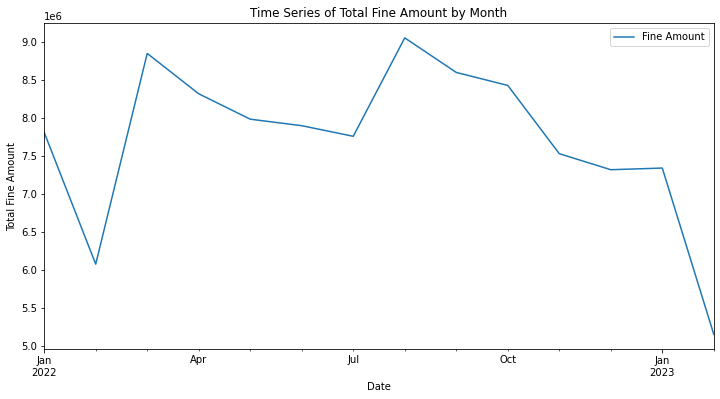

In [70]:
# this is too messy to see any trends, so let's do monthly average
grouped_month_df = df.groupby(pd.Grouper(key='Citation Issued DateTime', freq='M'))['Fine Amount'].sum().reset_index()

grouped_month_df.plot(x='Citation Issued DateTime', y='Fine Amount', figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Total Fine Amount')
plt.title('Time Series of Total Fine Amount by Month')
plt.show()

### Stratified by days of the week

In [94]:
# Now stratify by days of the week.
df['Day of Week'] = df['Citation Issued DateTime'].dt.day_name()

# Group the data by day of the week and calculate the sum of fine amounts:
df_grouped_day = df.groupby('Day of Week')['Fine Amount'].sum().reset_index()

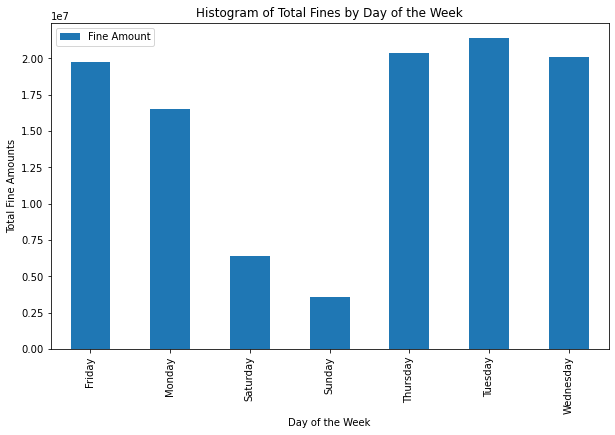

In [72]:
# Plot with pandas
df_grouped_day.plot(kind='bar', x='Day of Week', y='Fine Amount', figsize=(10,6))
plt.xlabel('Day of the Week')
plt.ylabel('Total Fine Amounts')
plt.title('Histogram of Total Fines by Day of the Week')
plt.show()

### By Hour, Weekdays

In [101]:
# adding an hour column
df['hour'] = df['Citation Issued DateTime'].dt.hour

# filtering by weekday
grouped_weekday_df = df[df['Day of Week'].isin(["Monday","Tuesday","Wednesday","Thursday","Friday"])]

# summing by hour
grouped_weekday_df = grouped_weekday_df.groupby('hour')['Fine Amount'].sum().reset_index()
grouped_weekday_df.head()

,hour,Fine Amount
0,0,2656493.0
1,1,534791.0
2,2,1911417.0
3,3,180656.0
4,4,737641.0


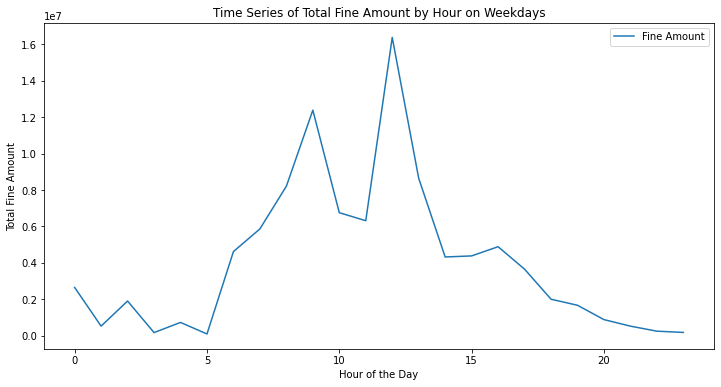

In [102]:
# plot
grouped_weekday_df.plot(x='hour', y='Fine Amount', figsize=(12,6))
plt.xlabel('Hour of the Day')
plt.ylabel('Total Fine Amount')
plt.title('Time Series of Total Fine Amount by Hour on Weekdays')
plt.show()


### By Hour, Weekends

In [107]:
# adding an hour column
df['hour'] = df['Citation Issued DateTime'].dt.hour

# filtering by weekend
grouped_weekend_df = df[df['Day of Week'].isin(["Saturday","Sunday"])]

# summing by hour
grouped_weekend_df = grouped_weekend_df.groupby('hour')['Fine Amount'].sum().reset_index()

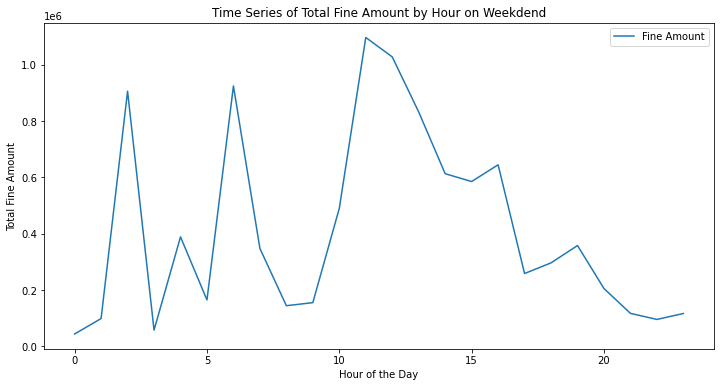

In [109]:
# plot
grouped_weekend_df.plot(x='hour', y='Fine Amount', figsize=(12,6))
plt.xlabel('Hour of the Day')
plt.ylabel('Total Fine Amount')
plt.title('Time Series of Total Fine Amount by Hour on Weekdend')
plt.show()